In [22]:
from torch import no_grad
from torch.cuda import empty_cache
import numpy as np
from PIL import Image
from skimage.color import label2rgb

from yoeo import CompleteUpsampler
from yoeo.utils import to_numpy

from interactive_seg_backend.configs import FeatureConfig, TrainingConfig
from interactive_seg_backend.main import featurise, train_and_apply
from interactive_seg_backend.file_handling import load_labels

import matplotlib.pyplot as plt

empty_cache()

In [11]:
path = "example_data/cast_iron_alloy.jpg"
img = Image.open(path).convert("RGB")
img_arr = np.array(img)
h, w, c = img_arr.shape

labels = load_labels("example_data/labels.tiff")

In [ ]:
upsampler = CompleteUpsampler("FEATUP", "../trained_models/fit_reg_f32.pth", device="cuda:0", to_half=True, to_eval=True)

with no_grad():
    lr_feats_for_vis = upsampler.get_lr_feats(img)
    hr_feats = upsampler.forward(img)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_small_patch14_reg4_dinov2.lvd142m)
INFO:timm.models._hub:[timm/vit_small_patch14_reg4_dinov2.lvd142m] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [ ]:
feat_cfg = FeatureConfig()
train_cfg = TrainingConfig(feat_cfg)
classical_feats = featurise(np.array(img), train_cfg)

(422, 800, 174) (420, 784)


In [17]:
deep_feats = to_numpy(hr_feats).transpose((1, 2, 0))
hybrid_feats = np.concatenate((classical_feats, deep_feats), axis= -1)

In [18]:
classical_seg, _, _ = train_and_apply(classical_feats, labels, train_cfg)
deep_seg, _, _ = train_and_apply(hybrid_feats, labels, train_cfg)

In [23]:
color_list = [[255, 255, 255], [0, 62, 131], [181, 209, 204], [250, 43, 0], [255, 184, 82]]
COLORS = np.array(color_list) / 255.0

def apply_labels_as_overlay(labels: np.ndarray, img: Image.Image, colors: list, alpha: float=1.0) -> Image.Image:
    labels_unsqueezed = np.expand_dims(labels, -1)

    overlay = label2rgb(labels, colors=colors[1:], kind='overlay', bg_label=0, image_alpha=1, alpha=alpha)
    out = np.where(labels_unsqueezed, overlay * 255, np.array(img)).astype(np.uint8)
    img_with_labels = Image.fromarray(out)
    return img_with_labels

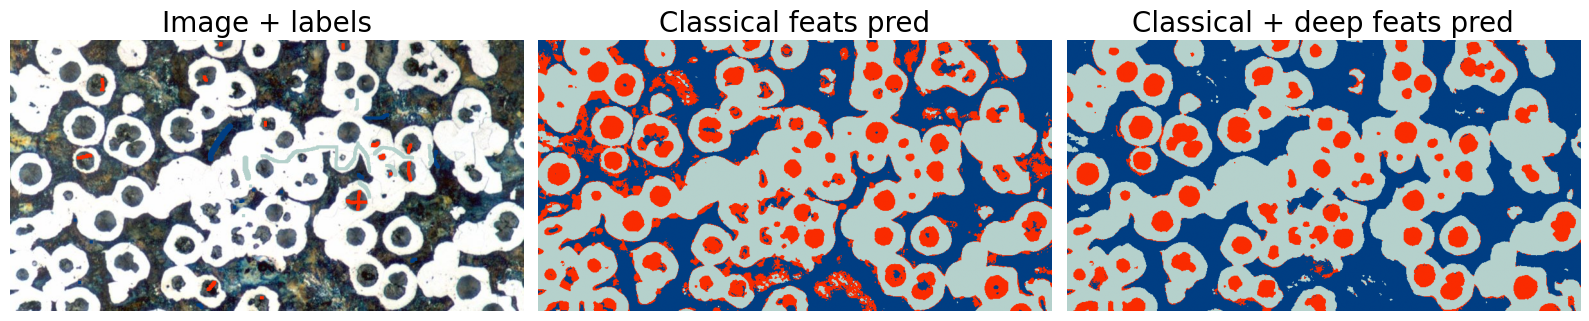

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

img_plus_labels = apply_labels_as_overlay(labels, img, COLORS)

classical_seg_recoloured = label2rgb(classical_seg, None, COLORS[1:], bg_label=-1)
deep_seg_recoloured = label2rgb(deep_seg, None, COLORS[1:], bg_label=-1)
to_plt = [img_plus_labels, classical_seg_recoloured, deep_seg_recoloured]
titles = ["Image + labels", "Classical feats pred", 'Classical + deep feats pred']

for arr, ax, title in zip(to_plt, axs, titles):
    ax.imshow(arr)
    ax.set_axis_off()
    ax.set_title(title, fontsize=20)
plt.tight_layout()